In [186]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import clear_output
import pathlib
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)
AUTOTUNE = tf.data.AUTOTUNE
%matplotlib inline

In [187]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
LAMBDA = 10
EPOCHS = 20

In [188]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [189]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [190]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [191]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [192]:
def preprocess_image_test(image, label):
  image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = normalize(image)
  return image

In [193]:
def load_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  return image

In [194]:
data_root = pathlib.Path("./")
paris_train_paths = list(data_root.glob('./paris/train/*'))
paris_test_paths = list(data_root.glob('./paris/test/*'))

bsln_train_paths = list(data_root.glob('./bsln/train/*'))
bsln_test_paths = list(data_root.glob('./bsln/test/*'))

paris_train_paths = [str(path) for path in paris_train_paths]
paris_test_paths = [str(path) for path in paris_test_paths]

bsln_train_paths = [str(path) for path in bsln_train_paths]
bsln_test_paths = [str(path) for path in bsln_test_paths]

In [195]:
train_paris_ds = tf.data.Dataset.from_tensor_slices(paris_train_paths)
train_paris = train_paris_ds.map(load_image, num_parallel_calls=AUTOTUNE)
train_paris = tf.data.Dataset.zip((train_paris, ()))

test_paris_ds = tf.data.Dataset.from_tensor_slices(paris_test_paths)
test_paris = test_paris_ds.map(load_image, num_parallel_calls=AUTOTUNE)
test_paris = tf.data.Dataset.zip((test_paris, ()))


train_bsln_ds = tf.data.Dataset.from_tensor_slices(bsln_train_paths)
train_bsln = train_bsln_ds.map(load_image, num_parallel_calls=AUTOTUNE)
train_bsln = tf.data.Dataset.zip((train_bsln, ()))

test_bsln_ds = tf.data.Dataset.from_tensor_slices(bsln_test_paths)
test_bsln = test_bsln_ds.map(load_image, num_parallel_calls=AUTOTUNE)
test_bsln = tf.data.Dataset.zip((test_bsln, ()))

In [196]:
train_paris = train_paris.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_bsln = train_bsln.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_paris = test_paris.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_bsln = test_bsln.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [197]:
sample_paris = next(iter(train_paris))
sample_bsln = next(iter(train_bsln))

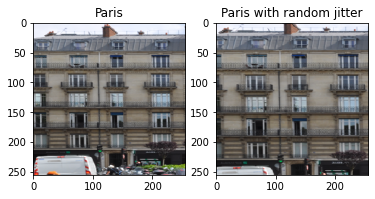

In [198]:
plt.subplot(121)
plt.title('Paris')
plt.imshow(sample_paris[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Paris with random jitter')
plt.imshow(random_jitter(sample_paris[0]) * 0.5 + 0.5)

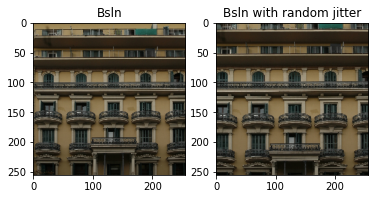

In [199]:
plt.subplot(121)
plt.title('Bsln')
plt.imshow(sample_bsln[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Bsln with random jitter')
plt.imshow(random_jitter(sample_bsln[0]) * 0.5 + 0.5)

In [200]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

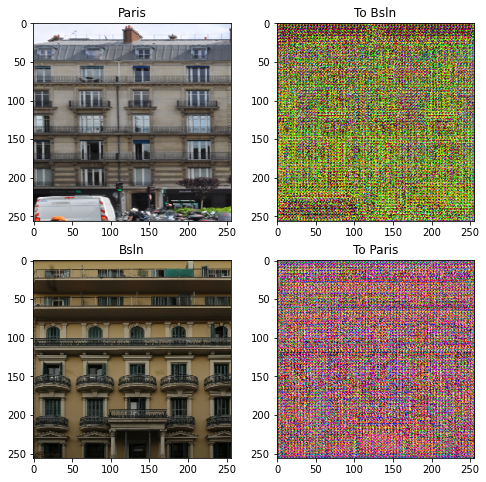

In [201]:
to_bsln = generator_g(sample_paris)
to_paris = generator_f(sample_bsln)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_paris, to_bsln, sample_bsln, to_paris]
title = ['Paris', 'To Bsln', 'Bsln', 'To Paris']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

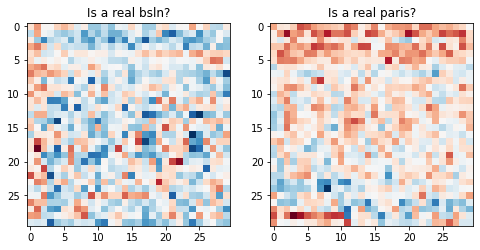

In [202]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real bsln?')
plt.imshow(discriminator_y(sample_bsln)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real paris?')
plt.imshow(discriminator_x(sample_paris)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [203]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [204]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [205]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [206]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [207]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [208]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [209]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [210]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [211]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

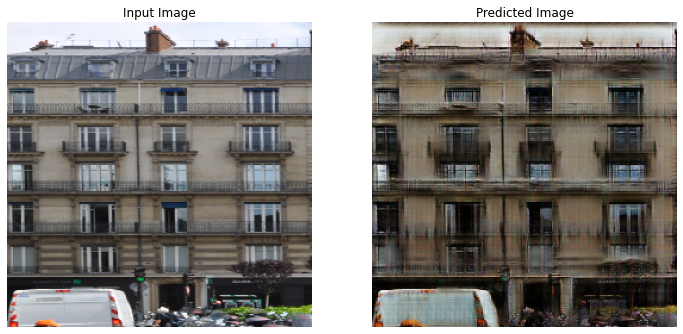

Saving checkpoint for epoch 20 at ./checkpoints/train\ckpt-21
Time taken for epoch 20 is 6.2795000076293945 sec



In [212]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_paris, train_bsln)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1


  clear_output(wait=True)
  # 使用一致的图像（sample_paris），以便模型的进度清晰可见。
  generate_images(generator_g, sample_paris)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

巴黎转巴塞罗那

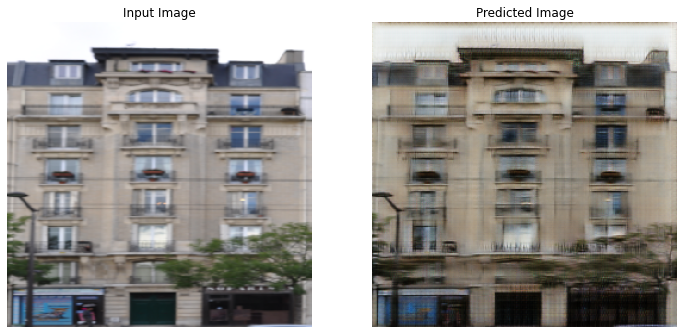

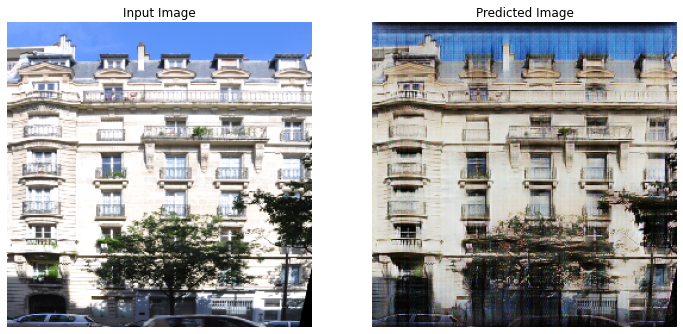

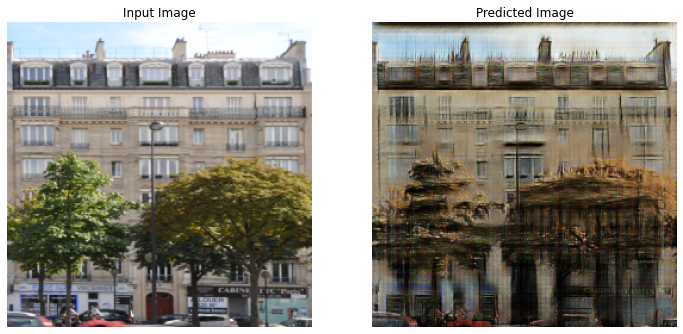

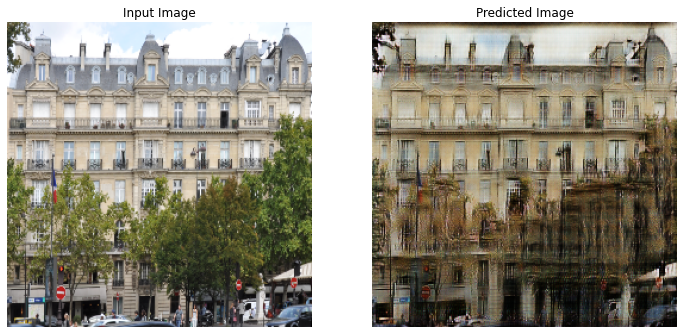

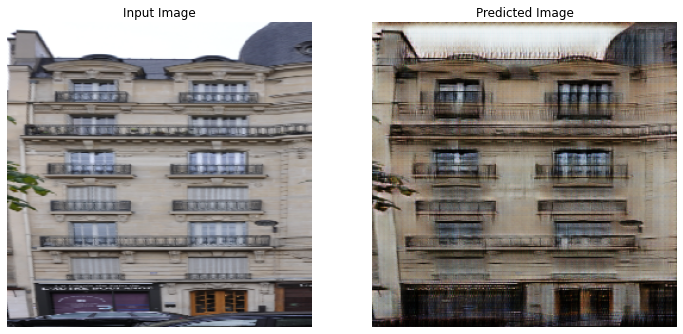

In [213]:
# Run the trained model on the test dataset
for inp in test_paris.take(5):
  generate_images(generator_g, inp)

巴塞罗那转巴黎

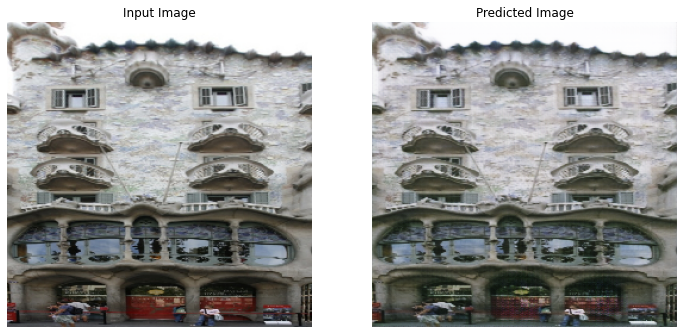

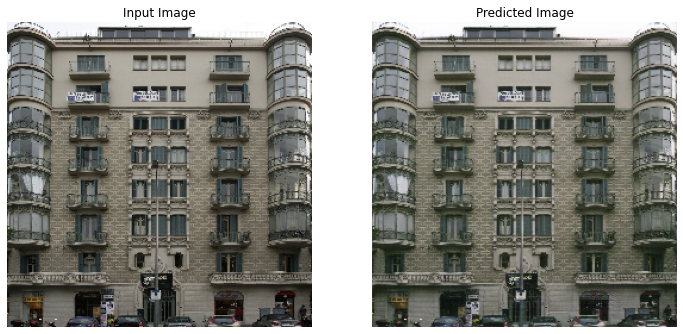

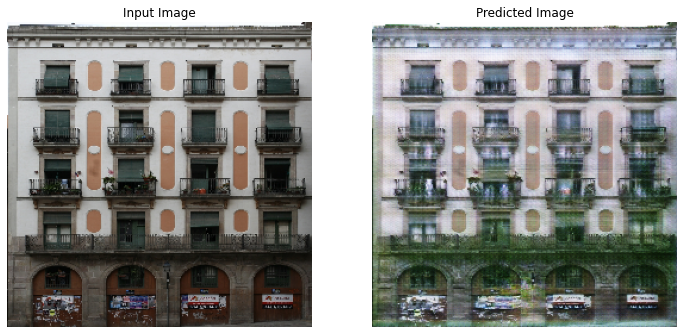

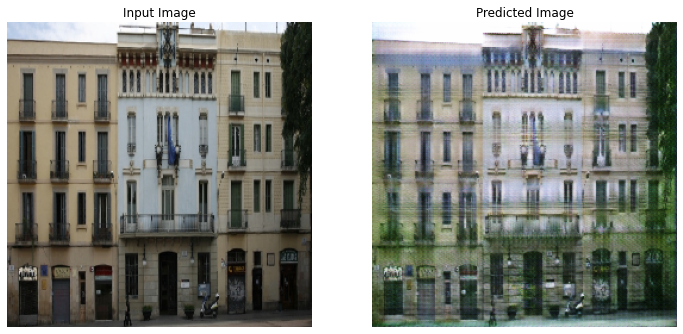

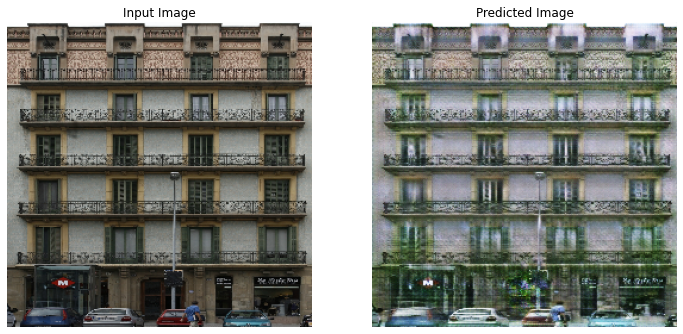

In [214]:
# Run the trained model on the test dataset
for inp in test_bsln.take(5):
  generate_images(generator_f, inp)

保存模型

In [215]:
generator_g.save("generator_g")
generator_f.save("generator_f")

INFO:tensorflow:Assets written to: generator_g\assets


INFO:tensorflow:Assets written to: generator_g\assets


INFO:tensorflow:Assets written to: generator_f\assets


INFO:tensorflow:Assets written to: generator_f\assets


加载模型

In [216]:
new_gg = tf.keras.models.load_model('generator_g')
new_gf = tf.keras.models.load_model('generator_f')